# Shepherd et al., Image Segmentation

RSGISLib is a set of Python modules which have been developed over the years to support our data processing needs.

The modules provide a set of high level functions, at a similar level to ArcGIS / QGIS toolbox functions or tools in ENVI or Erdas Imagine. The idea is that you can join a number of functions together to undertake your analysis or put those functions within a loop and process a number of input images.

In this tutorial we will look at using the Shepherd et al., image segmentation to create image objects from an input image, which can then be used for further image analysis (e.g., classification). 


## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_


## 1. Import Modules

In [1]:
# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Import rsgislib module
import rsgislib

# Import rsgislib plotting module to help
# visualising the data
import rsgislib.tools.plotting

# Import shepherd segmentation module
from rsgislib.segmentation import shepherdseg

## 2. Visualise Input Image

Image Data Size: 931 x 947


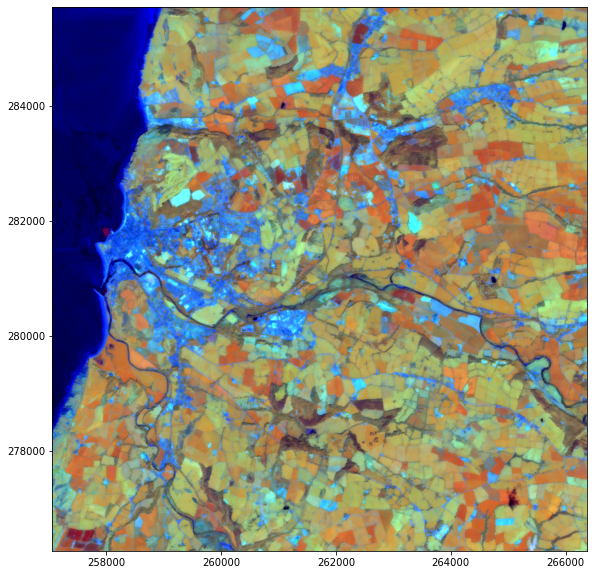

In [2]:
input_img = "../data/sen2_20210527_aber.tif"

### Input image
# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

## 3. Run Shepherd et al., Segmentation

Please note the output format needs to be an image file format which support Raster Attribute Tables (RATs), which basically means using either KEA or HFA (i.e., the Erdas Imagine \*.img format). For the majority of use cases you will most likely want to use the KEA file format.


In [3]:
out_clumps_img = "sen2_20210527_aber_segs.kea"
out_mean_img = "sen2_20210527_aber_meanimg.kea"
tmp_dir = "tmp"

shepherdseg.run_shepherd_segmentation(
    input_img,
    out_clumps_img,
    out_mean_img,
    tmp_dir,
    gdalformat="KEA",  # Output file format
    calc_stats=True,  # Calculate statistics on the output images
    no_stretch=False,  # Normalise the input bands by applying a 2 standard devation stretch
    no_delete=False,  # Delete the temporary files created during the processing
    num_clusters=60,  # The number of clusters (k) for the initial kMeans clustering
    min_n_pxls=100,  # Minimum number of pixels within a clump (segment)
    dist_thres=100,
    bands=[8, 9, 3],  # Just use bands 8 (NIR), 9 (SWIR) and 3 (Red)
    sampling=100,  # Speed up the kMeans clustering by only using every 100th pixel.
    km_max_iter=200,  # Maximum number of kMeans iterations
    process_in_mem=True,  # Do the process using in-memory datasets rather than to disk
    save_process_stats=False,
    img_stretch_stats="",
    kmeans_centres="",
    img_stats_json_file="",
)

Subsetting the image bands
New image width = 931 height = 947 bands = 3

Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.


Band[1] Min = 13 Mean = 448.339837374 (Std Dev = 170.100843825) max = 844
Band[2] Min = 5 Mean = 199.761055603 (Std Dev = 66.6435556283) max = 747
Band[3] Min = 11 Mean = 47.7343090729 (Std Dev = 26.2617507701) max = 1111
New image width = 931 height = 947 bands = 3

New image width = 931 height = 947 bands = 3

Create Input Image Mask.
Mask stretched Image.Image: tmp/sen2_20210527_aber_bselect.kea

	 Variable 'b1' is band 1
New image width = 931 height = 947 bands = 1

New image width = 931 height = 947 bands = 3

Deleting file: tmp/sen2_20210527_aber_stchdonly.kea
Deleting file: tmp/sen2_20210527_aber_stchdonly_off.kea
Deleting file: tmp/sen2_20210527_aber_stchdmaskonly.kea
Performing KMeans.
inputImage = tmp/sen2_20210527_aber_stchd.kea
outputMatrixFile = tmp/sen2_20210527_aber_kmeansclusters
numClust

## 4. Visualise the Segmentation

Firstly, we will visualise the raster clumps which are outputted from the segmentation algorithm. These are randomly assigned a colour so the clumps can be seen independently from one another.

Image Data Size: 931 x 947


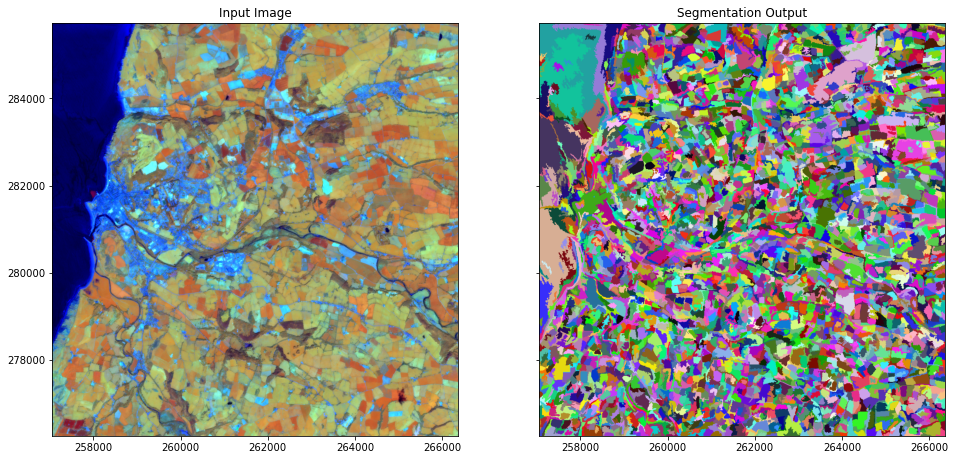

In [4]:
# Get the image data as a numpy array and the spatial bounding
# box of the image data. The returned array will be a colour (R,G.B)
# image with the colours from the colour table.
(
    img_seg_data,
    img_seg_coords,
    ldg_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(out_clumps_img)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_seg_data, extent=img_seg_coords)
ax2.title.set_text("Segmentation Output")

Secondly, we can visualise the mean image, which an image file with the same bands as the input image but with each pixel have the mean value for the clump. 

What you should hopefully be able to see from the figure below is that the mean clumps image looks visually very similar to the original image but smoother. If you can see features which have disappeared (e.g., small areas of woodland or individual fields) in the mean clumps image then this might be an indication that the segmentation is not preserving all the features you are interested in. You could decrease the `min_n_pxls` value to allow smaller clumps to be retained or increase the `num_clusters` so the kMeans has more change of finding the region of the feature space you are interested in preserving and therefore bring it out as a final clump.

Image Data Size: 931 x 947


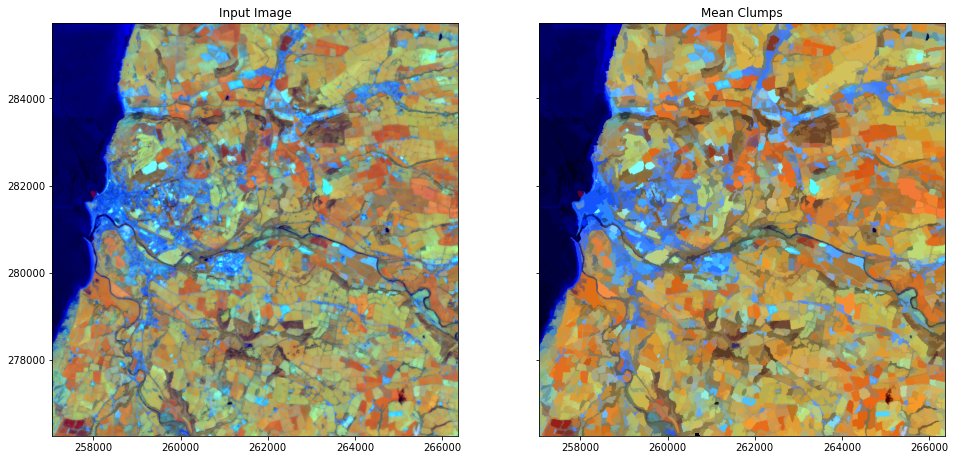

In [5]:
### Input image
# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_mean_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    out_mean_img, bands=[8, 9, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_mean_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_mean_data, no_data_val=0.0
)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_mean_data_strch, extent=img_seg_coords)
ax2.title.set_text("Mean Clumps")

## Create Vector Polygons for the Clumps

In some cases it is also useful to have a vector set of polygons to work with and visualise the segmentation. To vectorise the segmentation we will use the `polygonise_raster_to_vec_lyr` function within the `rsgislib.vectorutils.createvectors` module.


In [6]:
import rsgislib.vectorutils.createvectors

rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file="sen2_20210527_aber_segs.gpkg", # The output vector file name and path
    out_vec_lyr="sen2_20210527_aber_segs",       # The output vector layer name
    out_format="GPKG",                           # The output vector format
    input_img=out_clumps_img,                    # The input segmentation image
    img_band=1,                                  # The band within the input image
    mask_img=out_clumps_img,                     # A mask image (usually the same as the input image)
    mask_band=1,                                 # The band within the mask image
)

 24%|████████████████████████████████████▉                                                                                                                     | 24/100 [00:00<00:00, 217.82it/s]

Polygonising...


101it [00:00, 122.04it/s]                                                                                                                                                                        

Completed


### Visualise Segmentation Vector

Clearly, opening `sen2_20210527_aber_segs.gpkg` within QGIS or a GIS application would be the best way to interactively visualise this data but we can also make a plot of this using python:


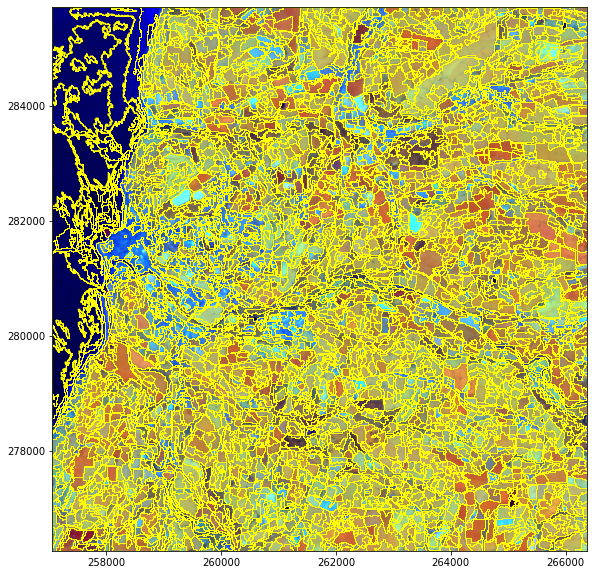

In [9]:
# Import the geopandas module
import geopandas

# Use geopandas to read the vector layer
segs_gdf = geopandas.read_file("sen2_20210527_aber_segs.gpkg", layer="sen2_20210527_aber_segs")


# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons with no face colour and an edge colour of yellow. 
# i.e., just the polygon outlines in yellow.
segs_gdf.plot(ax=ax, facecolor="none", edgecolor="yellow")

# Display the image data previously read in and stretched.
ax.imshow(img_data_strch, extent=img_coords)
